In [71]:
import pdb

In [252]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass

@dataclass
class ProcessConfig:
    """configure the data generating process"""
    period: int = 40
    seq_len: int = 10000
    t_start: int = 0
    num_seeds: int = 3 

class DataGeneratingProcess:
    """data generating process"""
    def __init__(self, cfg):
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.period = cfg.period
        self.t_start = cfg.t_start

    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 10000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(np.arange(self.t_start, self.t_start + self.seq_len))

        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        # generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, self.seq_len)
        x2 = np.random.uniform(1, 2, self.seq_len)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=self.seq_len)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        tind = np.array((np.arange(self.t_start, self.t_start + self.seq_len) % T) < (T // 2))
        tind = tind.astype(int)
        ind = np.where(tind == 1)[0]

        Ydat = Xdat > 0
        Ydat[ind] = Xdat[ind] < 0
        Ydat = Ydat.astype(int)

        Xdat = Xdat.reshape(-1, 1)

        return Xdat, Ydat, tind
    
    def generate_at_time(self, t, num_samples):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor
        """
        # Generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, num_samples)
        x2 = np.random.uniform(1, 2, num_samples)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=num_samples)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        if (t % T) < (T // 2):
            Ydat = Xdat < 0
        else:
            Ydat = Xdat > 0

        Xdat = Xdat.reshape(-1, 1)
        tdat = t * np.ones(num_samples)

        x = torch.from_numpy(Xdat).float()
        y = torch.from_numpy(Ydat).long()
        t = torch.from_numpy(tdat).float()
        return x, y, t
    
class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, idx, run_id, test, past=None):
        self.x = torch.from_numpy(data['x'][run_id]).float()
        self.y = torch.from_numpy(data['y'][run_id]).long()
        self.t = torch.from_numpy(data['t'][run_id]).float()

        if test:
            # Use data from time 'idx' onwards for testing
            test_idx = torch.where(self.t >= idx)
            self.x = self.x[test_idx]
            self.y = self.y[test_idx]
            self.t = self.t[test_idx]
        else:
            if past is None:
                #  # Use data up to time 'idx' onwards for training (full history)
                train_idx = torch.where(self.t < idx)
                self.x = self.x[train_idx]
                self.y = self.y[train_idx]
                self.t = self.t[train_idx]
            else:
                # Use the most recent past data up to time 'idx' onwards for training (partial history)
                self.x = self.x[run_id, idx-past:idx]
                self.y = self.y[run_id, idx-past:idx]
                self.t = self.t[run_id, idx-past:idx]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

In [253]:
import torch.nn as nn

class TimeEmbedding(nn.Module):
    """form the time-embedding"""
    def __init__(self, tdim=10):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, in_dim=1, out_dim=2, hidden_dim=32, tdim=50, prospective=False):
        super(MLP, self).__init__()
        self.prospective = prospective
        if prospective:
            self.time_embed = TimeEmbedding(tdim=tdim)
            self.fc1 = nn.Linear(in_dim + tdim, hidden_dim)
        else:
            self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, t):
        if self.prospective:
            t = self.time_embed(t.unsqueeze(-1))
            x = torch.cat([x, t], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [254]:
import random
import sys
sys.path.append('../')
from deep_nets.utils.bgd import BGD

def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloaders(dp, t, seed, past=None):
    """obtain the dataloaders"""
    if past:
        if t < 16:
            train_dataset = SyntheticDataset(dp.data, t, seed, test=False, past=None)
        else:
            train_dataset = SyntheticDataset(dp.data, t, seed, test=False, past=past)
    else:
        train_dataset = SyntheticDataset(dp.data, t, seed, test=False, past=None)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True)
    ttest_dataset = TensorDataset(*dp.generate_at_time(t, 500))

    if t < 32:
        bs = 2
    else:
        if past:
            if t < 8: bs = 2
            else: bs = 8
        else:
            bs = 32
            
    trainloader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader


def get_optimizer(model, bgd=False):
    """Obtain the appropriate optimizer"""
    if bgd:
        params = [{'params': [p]} for p in model.parameters()]
        optimizer = BGD(params, std_init=0.01)
    else:
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=0.1,
            momentum=0.9, 
            nesterov=True,
            weight_decay=0.00001
        )
    return optimizer

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, test_loader, ttest_loader, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.ttest_loader = ttest_loader

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optimizer

        self.device = device
        self.verbose = verbose

        self.bgd = True if optimizer.__class__.__name__ == 'BGD' else False

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch

            if self.bgd:
                bs = x.size(0)
                for mc_iter in range(10):
                    self.optimizer.randomize_weights()
                    outputs = self.model(x, t)
                    loss = self.criterion(outputs.squeeze(), y)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.aggregate_grads(bs)
            else:
                outputs = self.model(x, t)
                loss = self.criterion(outputs.squeeze(), y)
                self.optimizer.zero_grad()  
                loss.backward()  

            self.optimizer.step() 
            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def evaluate(self, model=None):
        if model:
            self.model = model
        self.model.eval()
        perrs = []
        with torch.no_grad():
            for batch in self.test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                perrs.append(err.cpu().numpy())
        perrs = np.concatenate(perrs)
        ploss = perrs.mean()

        errs = []
        with torch.no_grad():
            for batch in self.ttest_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errs.append(err.cpu().numpy())
        iloss = np.concatenate(errs).mean()
        return iloss, ploss, perrs

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch()
            if self.verbose:
                print(f'Epoch [{epoch + 1}/{num_epochs}], '
                    f'Train Loss: {train_loss:.4f}, ')
        print(f"training loss at last epoch: {train_loss:.3f}")

#### Train a PL model from t=0 to t=1000 and test at t=1e9

In [255]:
# configure and obtain the data generating process
period = 40
cfg = ProcessConfig(
    period=period,
    seq_len=10000,
    num_seeds=1
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

# device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# train a prospective learner at t = 1000
t = 1000
seed = 1996
trainloader, testloader, ttestloader = get_dataloaders(dp, t, 0)

model = MLP(prospective=True, tdim=50)
model.to(device)
optimizer = get_optimizer(model)
trainer = Trainer(model, trainloader, testloader, ttestloader, optimizer, device)
trainer.train(num_epochs=100)

iloss, ploss, _ = trainer.evaluate()
print(f"Prospective Loss at t = {t}: {ploss:.3f}")
print(f"Instantaneous Loss at t = {t}: {iloss:.3f}")

training loss at last epoch: 0.000
Prospective Loss at t = 1000: 0.000
Instantaneous Loss at t = 1000: 0.000


In [256]:
# evaluate the trained prospective learner at t = 1,000,000,000
ttest = 1e20
ttest_dataset = TensorDataset(*dp.generate_at_time(ttest, 500))

ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )

errs = []
with torch.no_grad():
    for batch in ttestloader:
        batch = [b.to(device) for b in batch]
        x, y, t = batch
        logits = model(x, t)
        probs = torch.softmax(logits, dim=1)
        err = (probs.argmax(dim=1) != y).float()
        errs.append(err.cpu().numpy())
iloss_at_ttest = np.concatenate(errs).mean()

print(f"Instantaneous Loss at t = {ttest}: {iloss:.3f}")

Instantaneous Loss at t = 1e+20: 0.000


#### Train a PL model from t=1e9 to t=1e9+1000 and test at t=1

In [257]:
# configure and obtain the data generating process
period = 40
t_start = 1e9
cfg = ProcessConfig(
    period=period,
    seq_len=10000,
    num_seeds=1,
    t_start=t_start
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

# device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# train a prospective learner at t = 1000
t = t_start + 1000
trainloader, testloader, ttestloader = get_dataloaders(dp, t, 0)

model = MLP(prospective=True, tdim=50)
model.to(device)
optimizer = get_optimizer(model)
trainer = Trainer(model, trainloader, testloader, ttestloader, optimizer, device)
trainer.train(num_epochs=100)

iloss, ploss, _ = trainer.evaluate()
print(f"Prospective Loss at t = {t}: {ploss:.3f}")
print(f"Instantaneous Loss at t = {t}: {iloss:.3f}")

training loss at last epoch: 0.683
Prospective Loss at t = 1000001000.0: 0.507
Instantaneous Loss at t = 1000001000.0: 0.672


In [258]:
# evaluate the trained prospective learner at t = 1,000,000,000
ttest = 1
ttest_dataset = TensorDataset(*dp.generate_at_time(ttest, 500))

ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )

errs = []
with torch.no_grad():
    for batch in ttestloader:
        batch = [b.to(device) for b in batch]
        x, y, t = batch
        logits = model(x, t)
        probs = torch.softmax(logits, dim=1)
        err = (probs.argmax(dim=1) != y).float()
        errs.append(err.cpu().numpy())
iloss_at_ttest = np.concatenate(errs).mean()

print(f"Instantaneous Loss at t = {ttest}: {iloss:.3f}")

Instantaneous Loss at t = 1: 0.672


In [263]:
tdim = 100
time_embed = TimeEmbedding(tdim=tdim)

In [271]:
t_start = 1e12
seq_len = 1000
times = torch.arange(t_start, t_start+seq_len).view(-1, 1)
time_mat = time_embed(times).numpy()

In [272]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'from t=1000000000000.0 to t=1000000001000.0')

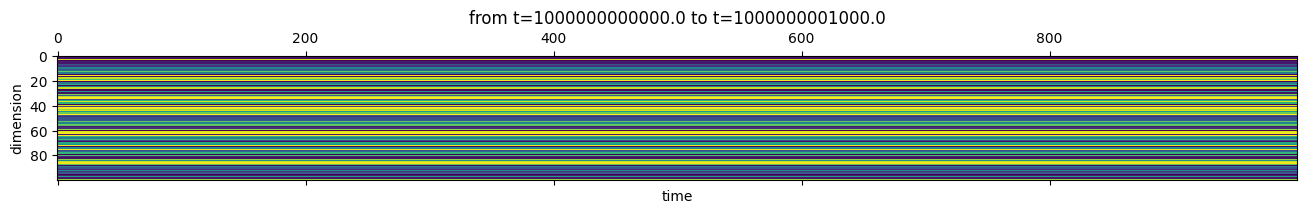

In [273]:
plt.matshow(time_mat.T)
plt.xlabel("time")
plt.ylabel("dimension")
plt.title(f"from t={t_start} to t={t_start+seq_len}")

Text(0, 0.5, 'last row of the time embedding matrix')

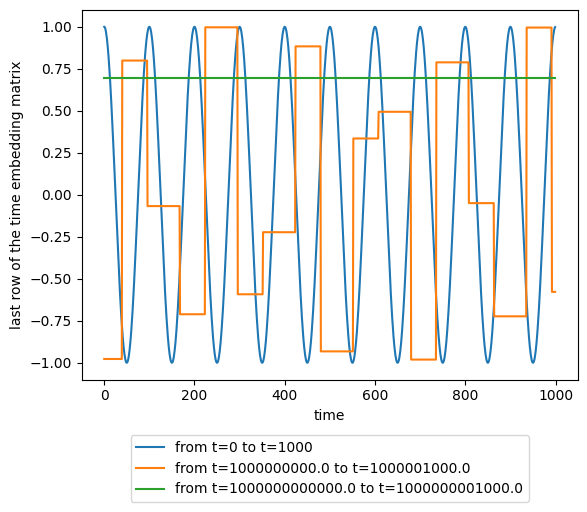

In [284]:
test_list = [0, 1e9, 1e12]

for t_start in test_list:
    seq_len = 1000
    times = torch.arange(t_start, t_start+seq_len).view(-1, 1)
    time_mat = time_embed(times).numpy()

    plt.plot(time_mat.T[-1, :], label=f"from t={t_start} to t={t_start+seq_len}")
plt.legend(loc=8, bbox_to_anchor=(0.5, -0.35))
plt.xlabel("time")
plt.ylabel("last row of the time embedding matrix")

In [247]:
torch.sin(torch.tensor(1e9))

tensor(0.5458)

In [248]:
np.sin(1e9)

0.5458434494486996

In [249]:
a = (2 * np.pi) / 100 * times % (2 * math.pi)

In [250]:
a = torch.sin(a)

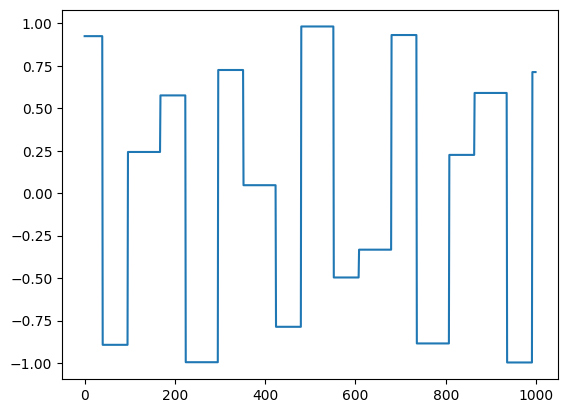

In [251]:
plt.plot(a)